In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
import os

def load_data(directory1, directory2, label1, label2):
    data = []
    labels = []

    for file in os.listdir(directory1):
        file_path = os.path.join(directory1, file)
        data.append(file_path)
        labels.append(label1)
        
    for file in os.listdir(directory2):
        file_path = os.path.join(directory2, file)
        data.append(file_path)
        labels.append(label2)
    
    return data, labels

# Usage:
male_directory = "C:/Users/aksha/Downloads/Neural_Network/Assignment 3/maleeyes"
female_directory = "C:/Users/aksha/Downloads/Neural_Network/Assignment 3/femaleeyes"
male_label = "M"
female_label = "F"

data, labels = load_data(male_directory, female_directory, male_label, female_label)


In [3]:
df = pd.DataFrame({"File": data, "Label": labels})
df = df.sample(frac=1).reset_index(drop=True)
df.shape

(11525, 2)

In [4]:
df.head()

,File,Label
0,C:/Users/aksha/Downloads/Neural_Network/Assign...,F
1,C:/Users/aksha/Downloads/Neural_Network/Assign...,F
2,C:/Users/aksha/Downloads/Neural_Network/Assign...,M
3,C:/Users/aksha/Downloads/Neural_Network/Assign...,M
4,C:/Users/aksha/Downloads/Neural_Network/Assign...,F


## EDA

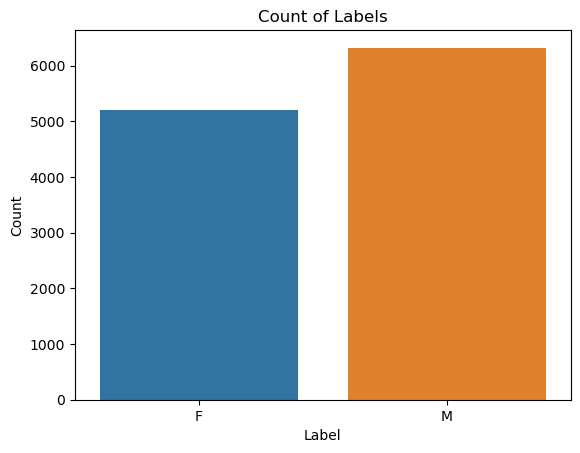

In [5]:
sns.countplot(data=df, x="Label")
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Labels')
plt.show()

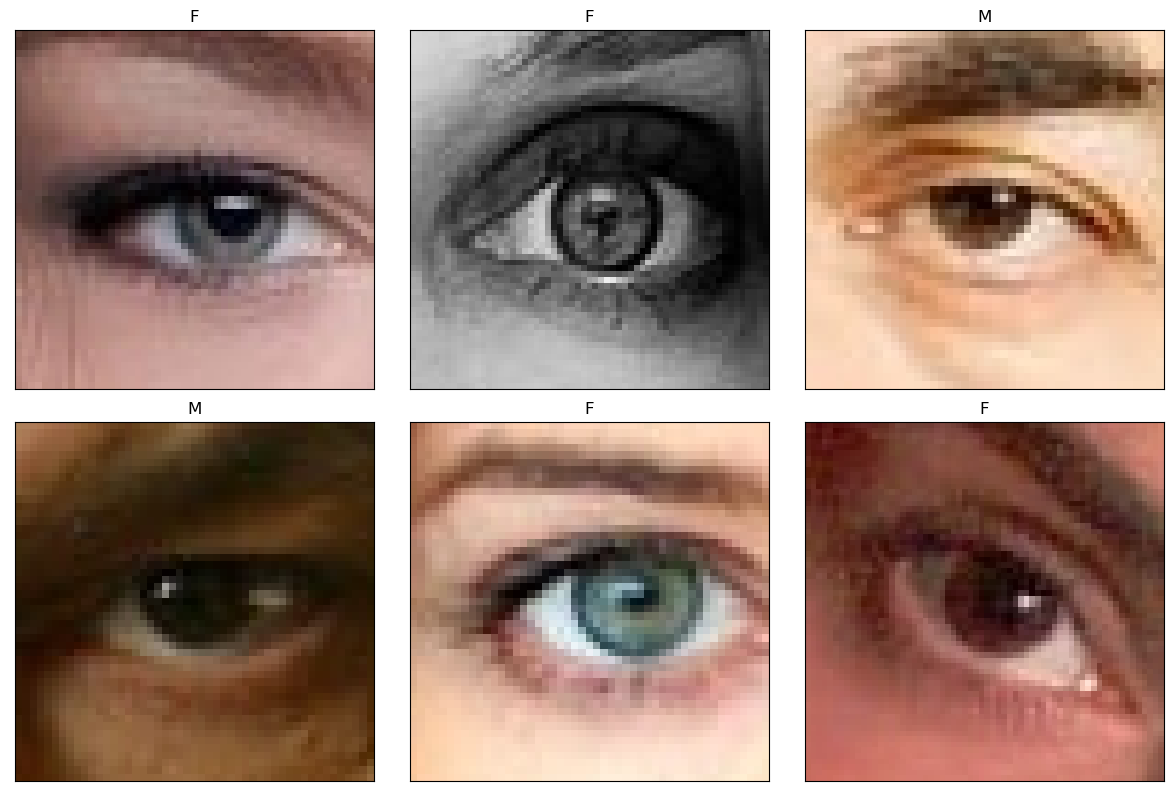

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    image = plt.imread(df.File[i])
    ax.imshow(image, cmap='viridis')
    ax.set_title(df.Label[i])
plt.tight_layout()
plt.show()


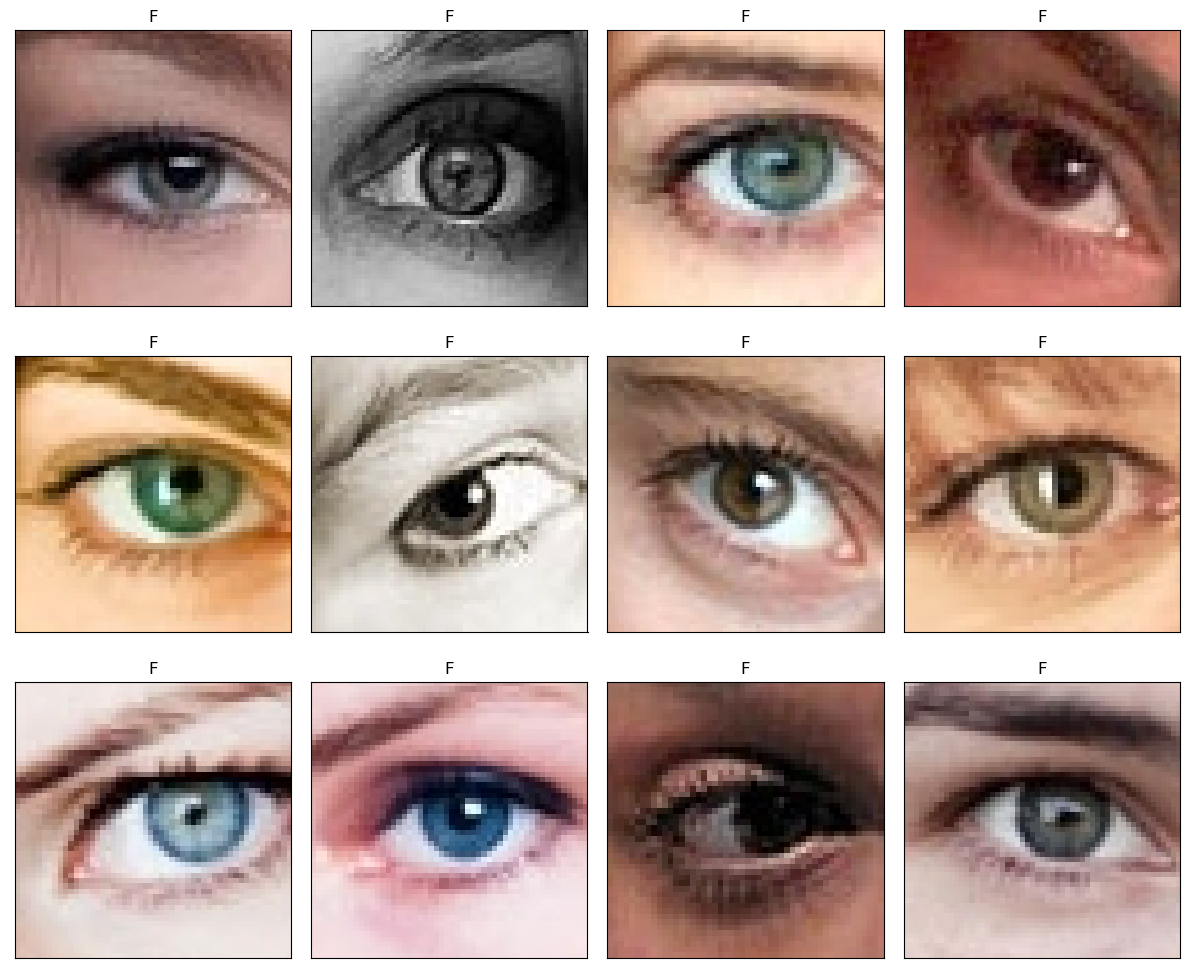

In [7]:
# Filter the DataFrame for female eyes
df_female = df[df['Label'] == 'F']

# Define the number of rows and columns for visualization
num_rows = 3
num_cols = 4

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 10),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    if i < len(df_female):
        image = plt.imread(df_female.File.iloc[i])
        ax.imshow(image, cmap='viridis')  # Change 'viridis' to the colormap you prefer
        ax.set_title(df_female.Label.iloc[i])
plt.tight_layout()
plt.show()


In [8]:
from tensorflow.keras.utils import load_img, img_to_array
# Define a function to load and preprocess the image
def preprocess_image(path):
    # Load image
    img = load_img(path, target_size=(64, 64))
    # Convert image to numpy array
    img = img_to_array(img)
    # Normalize image
    img = img / 255.0
    return img

# Apply the function to all images in the dataframe
data = np.array([preprocess_image(path) for path in df['File'].values])

# Convert labels to binary format (1 for 'M' and 0 for 'F')
labels = np.where(df['Label'].values == 'M', 1, 0)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Model 1 - Benchmark model (SVM)

In [10]:
from sklearn import svm
from sklearn.metrics import accuracy_score

# Flatten the image data
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Create a SVM Classifier
clf = svm.SVC(kernel='linear')
# Train the model using the training sets
clf.fit(X_train_flattened, y_train)

# Predict the response for test dataset
y_pred_SVC = clf.predict(X_test_flattened)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_SVC))

Accuracy: 0.8221258134490239


# Model 2 - Multilayer Perceptron Model 

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping


# Define the model
model = Sequential()
model.add(Flatten(input_shape=(64, 64, 3)))
model.add(Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))) # Increased neurons
# model.add(Dropout(0.5)) # Dropout
model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))) 
# model.add(Dropout(0.5)) # Added another dropout layer
model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))) 
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy']) # Reduced learning rate
 
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5) # Increased patience
 
# Train the model
history1 = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping]) # Increased batch size
MLP_y_pred = (model.predict(X_test) > 0.5).astype("int32")
 
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy of MLP: %.2f' % (accuracy*100))

Epoch 1/100


C:\Users\aksha\anaconda3\envs\project\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


116/116 [==============================] - 3s 25ms/step - loss: 27.5937 - accuracy: 0.6624 - val_loss: 17.5449 - val_accuracy: 0.7478
Epoch 2/100
116/116 [==============================] - 3s 23ms/step - loss: 11.6425 - accuracy: 0.7587 - val_loss: 7.4227 - val_accuracy: 0.8015
Epoch 3/100
116/116 [==============================] - 3s 23ms/step - loss: 5.8215 - accuracy: 0.7657 - val_loss: 4.8751 - val_accuracy: 0.6009
Epoch 4/100
116/116 [==============================] - 3s 24ms/step - loss: 4.0969 - accuracy: 0.7745 - val_loss: 3.5644 - val_accuracy: 0.8221
Epoch 5/100
116/116 [==============================] - 3s 24ms/step - loss: 3.2430 - accuracy: 0.7907 - val_loss: 2.9316 - val_accuracy: 0.8151
Epoch 6/100
116/116 [==============================] - 3s 25ms/step - loss: 2.7124 - accuracy: 0.7961 - val_loss: 2.5030 - val_accuracy: 0.7939
Epoch 7/100
116/116 [==============================] - 3s 25ms/step - loss: 2.3487 - accuracy: 0.7892 - val_loss: 2.1453 - val_accuracy: 0.8086
E

116/116 [==============================] - 3s 24ms/step - loss: 0.5690 - accuracy: 0.8690 - val_loss: 0.5960 - val_accuracy: 0.8465
Epoch 58/100
116/116 [==============================] - 3s 24ms/step - loss: 0.5914 - accuracy: 0.8509 - val_loss: 0.5733 - val_accuracy: 0.8628
Epoch 59/100
116/116 [==============================] - 3s 24ms/step - loss: 0.5696 - accuracy: 0.8648 - val_loss: 0.5647 - val_accuracy: 0.8666
Epoch 60/100
116/116 [==============================] - 3s 24ms/step - loss: 0.5740 - accuracy: 0.8614 - val_loss: 0.5658 - val_accuracy: 0.8661
Epoch 61/100
116/116 [==============================] - 3s 25ms/step - loss: 0.5854 - accuracy: 0.8536 - val_loss: 0.5477 - val_accuracy: 0.8736
Epoch 62/100
116/116 [==============================] - 3s 25ms/step - loss: 0.5752 - accuracy: 0.8515 - val_loss: 0.5582 - val_accuracy: 0.8677
Epoch 63/100
116/116 [==============================] - 3s 24ms/step - loss: 0.5652 - accuracy: 0.8602 - val_loss: 0.5692 - val_accuracy: 0.853

# Model 3 CNN

In [12]:
from keras.layers import Dropout
from keras.callbacks import Callback, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# Define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # Dropout
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # Dropout
model.add(Flatten()) 
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) # Dropout
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
 
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
 
# Train the model
history2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])
CNN_y_pred = (model.predict(X_test) > 0.5).astype("int32")
 
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy CNN: %.2f' % (accuracy*100))

Epoch 1/100
289/289 [==============================] - 20s 67ms/step - loss: 0.5129 - accuracy: 0.7409 - val_loss: 0.4026 - val_accuracy: 0.8121
Epoch 2/100
289/289 [==============================] - 19s 66ms/step - loss: 0.3843 - accuracy: 0.8328 - val_loss: 0.3412 - val_accuracy: 0.8681
Epoch 3/100
289/289 [==============================] - 19s 65ms/step - loss: 0.3248 - accuracy: 0.8608 - val_loss: 0.3704 - val_accuracy: 0.8291
Epoch 4/100
289/289 [==============================] - 19s 65ms/step - loss: 0.3018 - accuracy: 0.8706 - val_loss: 0.2552 - val_accuracy: 0.8959
Epoch 5/100
289/289 [==============================] - 19s 66ms/step - loss: 0.2621 - accuracy: 0.8919 - val_loss: 0.2202 - val_accuracy: 0.9093
Epoch 6/100
289/289 [==============================] - 19s 67ms/step - loss: 0.2466 - accuracy: 0.8992 - val_loss: 0.2152 - val_accuracy: 0.9106
Epoch 7/100
289/289 [==============================] - 19s 67ms/step - loss: 0.2228 - accuracy: 0.9079 - val_loss: 0.2056 - val_ac

# Intuition behind the architecture of the neural network (Model 2 & Model 3)

Model 2, the Multi-Layer Perceptron (MLP), constitutes a feedforward artificial neural network architecture. Its fundamental components include:

**Flatten Layer**: Responsible for transforming the 2D matrix of pixels into a 1D array, allowing seamless input into subsequent dense layers.

**Dense Layers**: Serving as the core building blocks of the model, these layers are densely interconnected. Each neuron in a layer receives inputs from every neuron in the preceding layer. The model incorporates multiple dense layers employing the 'relu' activation function, which introduces non-linearity. The final layer utilizes the 'sigmoid' activation function, particularly suitable for binary classification tasks.

**Regularization**: Employing L1 and L2 regularization techniques to prevent overfitting by adding penalties to the loss function, aiding in generalization and preventing excessive reliance on specific features during training.

**Early Stopping**: Implemented as a form of regularization strategy, early stopping mitigates overfitting during iterative training processes (e.g., gradient descent). It halts the training process when the model's performance ceases to improve on a held-out validation dataset, thereby preventing excessive training that might lead to overfitting.


Model 3, the Convolutional Neural Network (CNN), specializes in handling image processing, clustering, and classification tasks. The primary components integrated into this model encompass:

**Conv2D Layers**: These layers execute the convolution operation, utilizing small sliding windows to process the input data and extract various features.

**MaxPooling2D Layers**: These layers play a pivotal role in reducing the spatial dimensions (width and height) of the input volume. This reduction is instrumental in decreasing the computational complexity of the model.

**Dropout Layers**: Implemented as a regularization technique, these layers combat overfitting by randomly deactivating neurons during the training phase, thus enhancing the network's generalization capabilities.

**Flatten Layer**: This layer facilitates the transformation of the 2D matrix into a 1D array, enabling seamless integration with the subsequent dense layers.

**Dense Layer**: Responsible for conducting classification tasks on the features extracted by the convolutional and pooling layers. Within this layer, the 'relu' activation function is employed.

**Early Stopping**: An essential component utilized to prevent overfitting, early stopping halts the training process if the model's performance ceases to improve on a held-out validation dataset.

# Techniques used and their purpose  (Model2):

**Kernel Regularization (L1/L2)**: 
kernel_regularizer=l1_l2(l1=0.001, l2=0.001)
Used to add penalties to the loss function to prevent overfitting by reducing the complexity of the model.

**Early Stopping**: Controls the number of epochs during training based on the validation loss, preventing the model from overfitting to the training data.

**Optimizer - Adam**:
optimizer=Adam(lr=0.0001)
The 'Adam' optimizer is chosen for optimizing the network's weights during training. It adapts the learning rates of each parameter individually, providing faster convergence and efficient optimization. The learning rate (lr) is set to a lower value (0.0001) to regulate the step size during weight updates.

**Dense Layer** :
model.add(Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
model.add(Dense(1, activation='sigmoid'))
The primary purpose of the dense layer in an MLP is to process and transform the input data received from the previous layer. Each neuron in a dense layer is connected to every neuron from the preceding layer, forming a fully connected network structure. This connectivity allows the dense layer to learn complex patterns and relationships within the data by applying linear and non-linear transformations.
**Flatten Layer**:
model.add(Flatten(input_shape=(64, 64, 3)))
This layer serves as the input layer of the network. It flattens the 3D input image data into a 1D array to be fed into the subsequent dense layers. For this specific use case, it takes input images with a shape of 64x64 pixels and 3 color channels (RGB).

   
# Techniques used and their purpose  (Model3) :
**Dropout**: model.add(Dropout(0.25)) and model.add(Dropout(0.5))
Dropout layers are a form of regularization that randomly drops a fraction of neurons during training. This prevents overfitting by reducing interdependent learning among neurons, thereby improving the network's generalization ability.

**Early Stopping**: Early stopping is implemented to monitor the validation loss during training. If the loss doesn't improve after a certain number of epochs defined by the 'patience' parameter (3 in this case), the training is stopped to prevent overfitting.

**Dense Layer** :  model.add(Dense(128, activation='relu')) and model.add(Dense(1, activation='sigmoid')) These dense (fully connected) layers process the flattened data. The first dense layer with 128 neurons applies the ReLU activation function to learn intricate patterns from the flattened data. The final dense layer with a single neuron uses the sigmoid activation function, producing a probability value for binary classification tasks.

**MaxPooling2D Layers**:
model.add(MaxPooling2D(pool_size=(2, 2)))
These layers perform max pooling operations to reduce the spatial dimensions of the data extracted by the convolutional layers. It helps in downsampling the features while retaining the most significant information.

**Flatten**:model.add(Flatten()) This layer is used to flatten the multi-dimensional output obtained after convolution and pooling into a 1D array. It prepares the data for input into the fully connected layers. 

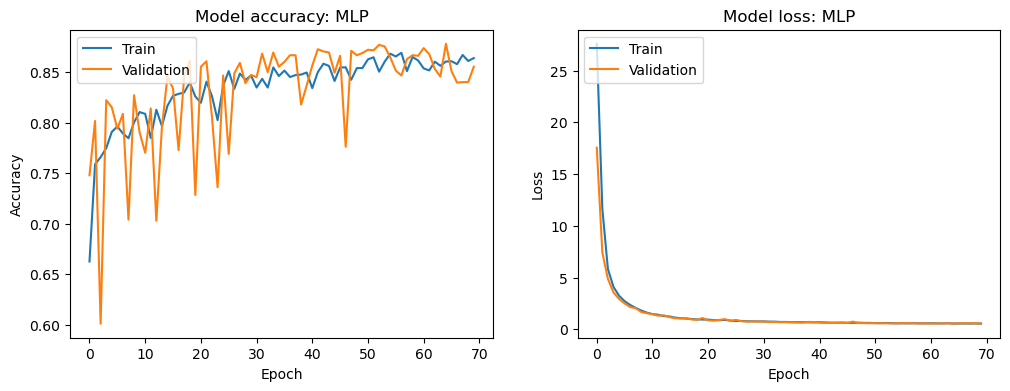

In [13]:
# Training and Test Accu
# Train the model and save the history

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy: MLP')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss: MLP')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

There are two plots which represents the Model accuracy and model loss of MLP.
In Model accuracy we can see that the epoch training started from 0where the accuracy was less than 50% for train data and 71% for validation data. As it progressed the accuracy at step 55 was highest with 87%for train data and setp 48 saw the hihest accuracy of 87% for validation accuracy. Finally, the step 74 was the last training which recorded both to be 84% which gave the overall to be 84%

In model Loss at step 0 training data had a loss of 28 and validation had a loss of 15 which decreases as the steps progresses. Finally at step 74 it can be observed that loss for both was recoreded to be less that 0.12.

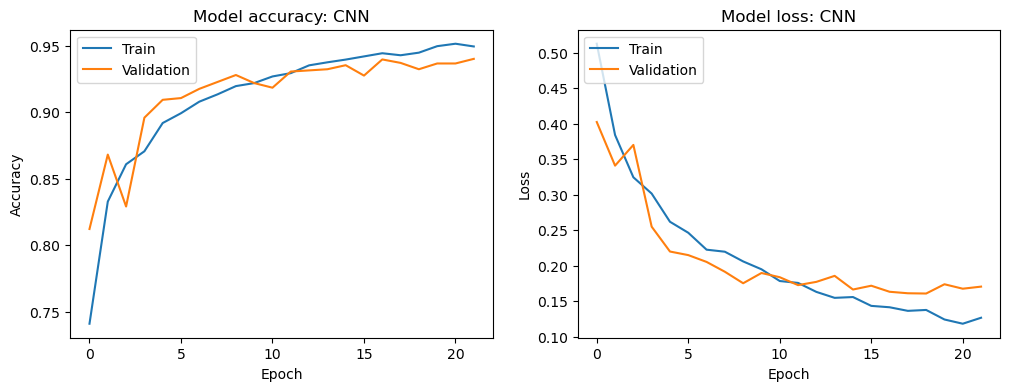

In [14]:
# Training and Test Accu
# Train the model and save the history

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy: CNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss: CNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

There are two plots represented for CNN.
Model accuracy of CNN can be observed that the in total there we 74 steps for training and at step 0 the accuracy for train data was 70% and validation data was 84%. As it progressed the accuracy for both sets kept on climbing where the highest accuracy for test data was observed at the final step for train data to be 92% and validation data acheieving 94% at step 13 at the final step it comes to 94%

Model loss at first step for train data was observed to be 0.58 and for validation loss was 0.40. As the steps in epoch progressed the loss in both cases were less that 0.20 which can be concluded that the model is learning at a considerable pace.


In [15]:
# Classification Report

# SVC
print(classification_report(y_test, y_pred_SVC))

# MLP
print(classification_report(y_test, MLP_y_pred))

# CNN
print(classification_report(y_test, CNN_y_pred))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1056
           1       0.83      0.84      0.84      1249

    accuracy                           0.82      2305
   macro avg       0.82      0.82      0.82      2305
weighted avg       0.82      0.82      0.82      2305

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1056
           1       0.83      0.92      0.87      1249

    accuracy                           0.86      2305
   macro avg       0.86      0.85      0.85      2305
weighted avg       0.86      0.86      0.85      2305

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1056
           1       0.93      0.96      0.95      1249

    accuracy                           0.94      2305
   macro avg       0.94      0.94      0.94      2305
weighted avg       0.94      0.94      0.94      2305



# Model Comparisions
Model 1 demonstrates moderate precision and recall for both Class 0 (precision 0.78, recall 0.77) and Class 1 (precision 0.82, recall 0.83). It achieves fairly balanced F1-scores for both classes (0.78 for Class 0 and 0.82 for Class 1), resulting in an 80% accuracy.

Model 2 exhibits lower precision for Class 0 (0.77) but higher recall (0.93), while displaying higher precision for Class 1 (0.94) but lower recall (0.77). The F1-scores are moderate for both Class 0 (0.84) and Class 1 (0.85), leading to an accuracy of 85%.

Model 3 showcases high precision and recall for both classes, surpassing 0.91 for both metrics. It achieves balanced F1-scores (0.92 for Class 0 and 0.93 for Class 1) with an accuracy of 92%.

# Conclusion:
Overall, Model 3 outperforms the other models, displaying higher precision, recall, F1-scores, and accuracy for both gender classes. Model 2 follows closely, showcasing strengths in certain aspects such as high precision for Class 1 but lower precision for Class 0. Model 1 trails behind in precision, recall, and accuracy compared to the other models.

# Recomendation
For gender classification based on eye-related features, Model 3 is the top recommendation due to its balanced performance in identifying both classes. Model 2 could be considered if a slightly lower accuracy is acceptable or for computational limitations. Model 1 might require further optimization to improve its overall performance in precision, recall, and accuracy.